## CSCI250 Capstone: 
#### By: Carsten Erlander and Jacob States
##### Description
Use a piezoelement, microphone, and button to record notes from a trombone and compare the audio data and piezo data. Then interpret that data by anaylzing the frequency of the notes played.
###### Recording Method
Upon button press begin recording and continue until button is pressed again or after 10 seconds. To record, the program will run two threads gathering data from the piezoelement and microphone.
Potential Challenges: Synced data
###### Storing Data
Once recording halts, both arrays (ideally the same length) will be saved into a single file to be retrieved and analyzed.
###### Data Analysis
- Graph both data sets (Y)
- Graph the fft of the data (Y)
- Determine the notes played (In progress)
- Big Brain: Processing
- Play back the notes on a buzzer (?)

In [1]:
# IMPORTS
import RPi.GPIO as GPIO
import numpy as np
import matplotlib.pyplot as plt
import adcUtil as adc
import time , pigpio, os, math

In [2]:
# GPIO SETUP
# Recording (Green) Button Setup
GPIO.setmode(GPIO.BCM)
bPin = 27
GPIO.setup(bPin, GPIO.IN, pull_up_down = GPIO.PUD_DOWN)
print("Recording Button set to pin:", bPin)
print("Recording Button default to:", GPIO.input(bPin), "\n")

# Interrupt (Red) Button Setup
intrPin = 25
GPIO.setup(intrPin, GPIO.IN, pull_up_down = GPIO.PUD_DOWN)
print("Interrupt Button set to pin:", intrPin)
print("Interrupt Button default to:", GPIO.input(intrPin),"\n")

# Recording LED
ledPin = 26
GPIO.setup(ledPin, GPIO.OUT)
print("Recording LED set to pin:", ledPin, "\n")

# Audio Gate pin Setup
gatePin = 24
GPIO.setup(gatePin, GPIO.IN, pull_up_down = GPIO.PUD_DOWN)
print("Audio Gate set to pin:", gatePin)
print("Audio Gate default to:", GPIO.input(gatePin), '\n')

# Buzzer pin Setup
buzzPin = 19
duty = 0.5
duration = 3
pi = pigpio.pi(port = 8887)
print("Buzzer set to pin:", buzzPin)
print("Buzzer duration set to:",3, "seconds")

Recording Button set to pin: 27
Recording Button default to: 0 

Interrupt Button set to pin: 25
Interrupt Button default to: 0 

Recording LED set to pin: 26 

Audio Gate set to pin: 24
Audio Gate default to: 0 

Buzzer set to pin: 19
Buzzer duration set to: 3 seconds


/tmp/ipykernel_25065/2132386878.py:17: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(ledPin, GPIO.OUT)


In [3]:
# Frequency Dictonary
# Note names, index is how many pitches above C0 the note is
# Frequency converted to index value by index=12log(base2)(frequency)-48

pitches=['C0','Db0','D0','Eb0','E0','F0','Gb0','G0','Ab0','A0','Bb0','B0',
         'C1','Db1','D1','Eb1','E1','F1','Gb1','G1','Ab1','A1','Bb1','B1',
         'C2','Db2','D2','Eb2','E2','F2','Gb2','G2','Ab2','A2','Bb2','B2',
         'C3','Db3','D3','Eb3','E3','F3','Gb3','G3','Ab3','A3','Bb3','B3',
         'C4','Db4','D4','Eb4','E4','F4','Gb4','G4','Ab4','A4','Bb4','B4',
         'C5','Db5','D5','Eb5','E5','F5','Gb5','G5','Ab5','A5','Bb5','B5',
         'C6','Db6','D6','Eb6','E6','F6','Gb6','G6','Ab6','A6','Bb6','B6',
         'C7','Db7','D7','Eb7','E7','F7','Gb7','G7','Ab7','A7','Bb7','B7',
         'C8','Db8','D8','Eb8','E8','F8','Gb8','G8','Ab8','A8','Bb8','B8']

In [5]:
# Moving Average Filter

def moving_avg(input, win):
    avg = np.ndarray([], dtype = 'float', order = 'C')   # defines empty avg array
    mov_sum = np.sum(input[:int(win)])                   # defines sum of values in window
    avg = np.append(avg, mov_sum/win)
    for i in range(int(len(input) - win)):
        mov_sum += (input[int(i + win)] - input[i]) # Shifts window to the right by one unit
        avg = np.append(avg, mov_sum/win)
        
    return avg

In [6]:
# Note Identity Function

def noteName(freq):                     #function to convert frequency to note name
    index=int(12*math.log2(freq)-48)    #convert frequency to index value of pitches list
    return pitches[index]               #return note name at index 

In [29]:
## RECORD FUNCTION

# Recording with Rec Button, Interrupt Button, rec LED, ADC, microphone (Audio wave)
# Once loop begins it will run for a set amount of time or until the interrupt button is pressed.
# To Record: Begin loop, then press record button in the set time interval. Recording will stop when time is up or when
#     interrupt button is pressed

# EDIT: add error for 0 dimensional array

# Initialize data arrays for time, audio, envelope, and gate
def record(dt = 15):
    arr_t    = np.ndarray([], dtype = 'float', order = 'C')
    arr_aud  = np.ndarray([], dtype = 'float', order = 'C') 
    arr_gate = np.ndarray([], dtype = 'int', order = 'C')

    try:
        to = time.time()                                         # Initial ime
        t  = to                                                  # Time counter
        dt = dt                                                  # Time interval for while loop
        intr = GPIO.input(intrPin)                               # Interrupt variable for interrupt button
        assert intr == 0                                         # Assertion for unpressed interrupt button (internal pull down)
    
        while t <= to + dt and intr == 0:                        # For dt seconds and while interrupt is unpressed...      
            rec  = GPIO.input(bPin)                              # NOTE to start time when rec button is pressed consider
            intr = GPIO.input(intrPin)                           #      putting the while loop within the following if statement
            if rec == 1:                                         # If rec button is pressed...
                rec  = GPIO.input(bPin)                             # Check rec button state
                intr = GPIO.input(intrPin)                          # Check intr button state
            
                GPIO.output(ledPin, True)                           # Turn on LED
                t    = time.time()                                  # record time, aud, env, and gate channels
                aud  = adc.readADC(channel = 0, device = 0)
                piz  = adc.readADC(channel = 1, device = 0)
                gate = GPIO.input(gatePin)
                arr_t    = np.append(arr_t, t-to)                   # append time, aud, env, and gate data to respective arrays
                arr_aud  = np.append(arr_aud, aud)                  
                arr_gate = np.append(arr_gate, gate)
            else:                                                # If rec button is unpressed...
                rec = GPIO.input(bPin)                              # Check rec button state      
                intr = GPIO.input(intrPin)                          # Check intr button state
            
                GPIO.output(ledPin, False)                          # Turn LED off
                t = time.time()                                     # Update time counter
        else:                                                 # Once time interval is complete or interrupted exit while loop
            GPIO.output(ledPin, False)                           # Turn LED off when loop finished

    except AssertionError:                                 # If interrupt button is pressed exits while loop
        print("Recording Interrupted")

    finally:                                               # Once complete deletes first data point from each array and prints
        if arr_t.ndim != 0:
            arr_t    = arr_t[1:]
            arr_aud  = arr_aud[1:] - np.mean(arr_aud)
            arr_gate = arr_gate[1:]
            print("Recording Complete")
            save = input("Do you want to save this file? (y/n)")
            if save == 'y':
                file_name = input("Enter name for file ")
                file_name = file_name + '.npz'
                np.savez(file_name, arr_t, arr_aud, arr_gate)
                print(file_name, '\n', np.load(file_name))
                print('With arrays:', '\n', np.load(file_name).files)
            else:
                print("Data not saved")
                pass
        else:
            print("Recording Interrupted before data was collected.")
            pass

In [30]:
record()

Recording Complete
Do you want to save this file? (y/n)y
Enter name for file test2
test2.npz 
With arrays: 
 ['arr_0', 'arr_1', 'arr_2']


In [8]:
%ls -l *.npz

-rw-r--r-- 1 pi pi 198894 Dec  5 19:40 A4_sine.npz
-rw-r--r-- 1 pi pi 149054 Dec  5 19:47 C4_sine.npz
-rw-r--r-- 1 pi pi 129762 Dec  5 18:08 capstone_B1.npz
-rw-r--r-- 1 pi pi 144322 Dec  5 18:39 capstone_Bb2.npz
-rw-r--r-- 1 pi pi 124582 Dec  4 15:05 capstone_Bb.npz
-rw-r--r-- 1 pi pi 131946 Dec  5 16:45 capstone_Bb_phone.npz
-rw-r--r-- 1 pi pi 113970 Dec  5 17:11 capstone_Bb_sine2.npz
-rw-r--r-- 1 pi pi 142054 Dec  5 16:46 capstone_Bb_sine.npz
-rw-r--r-- 1 pi pi 133010 Dec  4 15:05 capstone_D.npz
-rw-r--r-- 1 pi pi 128138 Dec  5 18:40 capstone_F.npz
-rw-r--r-- 1 pi pi 123098 Dec  5 18:01 capstone_G2.npz
-rw-r--r-- 1 pi pi 112570 Dec  5 18:04 capstone_G3.npz
-rw-r--r-- 1 pi pi 220958 Dec  5 18:35 capstone_G4.npz
-rw-r--r-- 1 pi pi 144770 Dec  4 15:03 capstone_g.npz
-rw-r--r-- 1 pi pi 154262 Dec  5 17:37 capstone_G.npz
-rw-r--r-- 1 pi pi  53490 Dec  5 17:35 capstone_test2.npz


In [31]:
os.remove('test2.npz')

In [13]:
# Load File to analyze

f_name = "capstone_Bb_sine2.npz"

file = np.load(f_name)

t    = file['arr_0']
aud  = file['arr_1']
gate = file['arr_2']
piz  = file['arr_3']

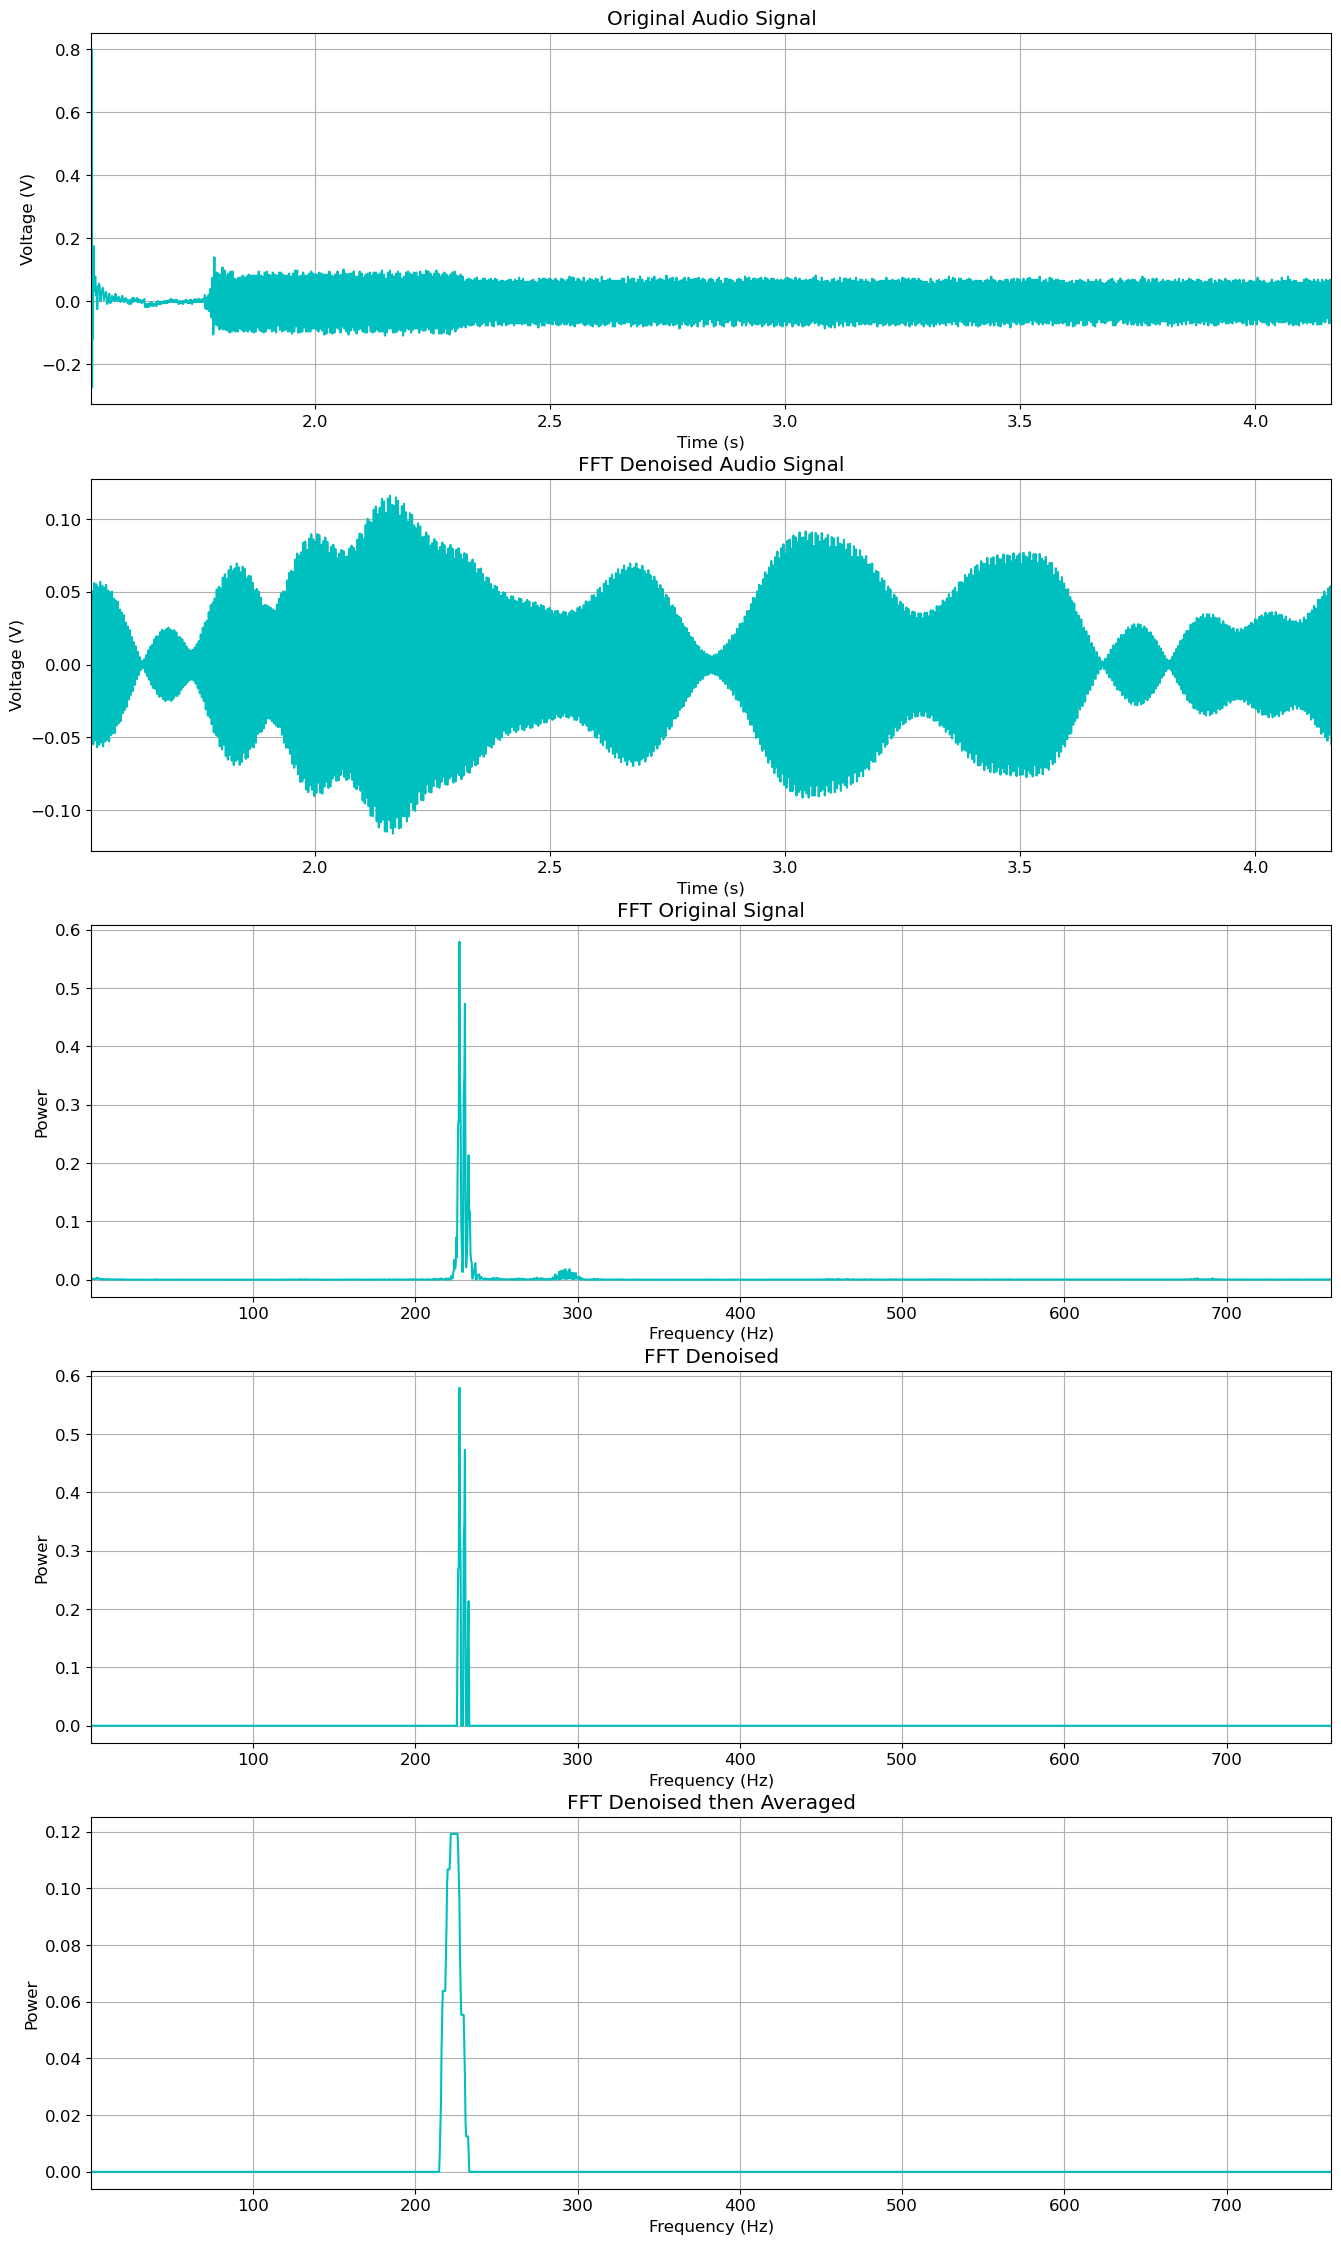

In [14]:
## Fast Fourier Transform
n = len(t)                                       # Number of samples
s = (t[n-1]-t[0])/n                              # Inverse of the Microphone Sample Rate
fhat = np.fft.fft(aud, n)                        # Fourier Transforms audio array
PSD  = np.real(fhat * np.conj(fhat) / n)         # Generates the Power Spectrum Density (PSD), Y-axis from the real part of FFT
freq = (1/(s*n)) * np.arange(n)                  # Generates X-axis for FFT
L = np.arange(1, np.floor(n/2), dtype ='int')    # Indicies for freq and PSD to be graphed. Include even integers of pi

## Filters
indices = PSD > 0.25*np.max(PSD)                 # Array mask for all frequencies 25% of max power            
PSDfilt = PSD * indices                          # Denoise PSD by applying array mask
ifhat   = indices * fhat                         # Applies mask to FFT of audio signal
ffilt   = np.fft.ifft(ifhat)                     # Inverse transform of filtered audio signal
ffilt   = np.real(ffilt)                         # Keeps only real values of filtered signal

win = 30                                         # Window size of moving average function
PSDfilt_avg = moving_avg(PSDfilt, win)           # Applies moving average to PSD
PSDfilt_avg = PSDfilt_avg[1:]                    # Ommits signals of frequency 0

## Graphs
plt.rcParams['figure.figsize'] = [16,28]
plt.rcParams.update({'font.size': 12})
fig,axs = plt.subplots(5,1)

# Original Audio Signal
plt.sca(axs[0])
plt.plot(t,aud, color = 'c')
plt.title('Original Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.xlim(t[0], t[-1])
plt.grid(True)

# FFT Denoised Audio Signal
plt.sca(axs[1])
plt.plot(t,ffilt, color = 'c')
plt.title('FFT Denoised Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.xlim(t[0], t[-1])
plt.grid(True)

# FFT of Original Signal
plt.sca(axs[2])
plt.plot(freq[L], PSD[L], color = 'c')
plt.title('FFT Original Signal')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid(True)

# Denoised FFT
plt.sca(axs[3])
plt.plot(freq[L], PSDfilt[L], color = 'c', label = 'Audio Signal')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.title('FFT Denoised')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid(True)

# Denoised and Averaged FFT
plt.sca(axs[4])
plt.plot(freq[L], PSDfilt_avg[L], color = 'c', label = 'Audio Signal')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.title('FFT Denoised then Averaged')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid(True)

plt.show()

In [23]:
def play_aud():
    freq_aud = freq[PSDfilt_avg.argmax()]                    # Choses dominant frequency in audio signal
    duty = 0.5                                               # Sets duty cycle of buzzer
    pi = pigpio.pi(port = 8887)
    print('Dominant Frequency was: ', freq_aud)
    print('Playing: ', noteName(freq_aud))
    
    pi.set_PWM_frequency(buzzPin, int(freq_aud))             # set frequency
    pi.set_PWM_dutycycle(buzzPin, int(duty * 255))           # set duty cycle
    time.sleep(duration)
    
    pi.set_PWM_dutycycle(buzzPin, 0)
    print('Playing stopped')

In [24]:
play_aud()

Dominant Frequency was:  221.85202257157144
Playing:  A3
Playing stopped
